# 使用 BiologicMPTReader 加载和分析 BioLogic MPT 文件

本笔记本演示了如何使用 `echemistpy` 中的 `BiologicMPTReader` 来加载单个 MPT 文件以及批量加载目录下的多个文件。

In [1]:
import pathlib
import matplotlib.pyplot as plt
import sys
import xarray as xr

# 强制重新加载模块
for m in list(sys.modules.keys()):
    if 'echemistpy' in m:
        del sys.modules[m]

from echemistpy.io.plugins.echem.BiologicMPTReader import BiologicMPTReader

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

In [2]:
# 定义测试数据目录
data_dir = pathlib.Path('docs/examples/echem')

# 列出目录下的所有 .mpt 文件
mpt_files = list(data_dir.rglob('*.mpt'))
print(f"找到 {len(mpt_files)} 个 MPT 文件:")
for f in mpt_files:
    print(f" - {f}")

找到 4 个 MPT 文件:
 - docs\examples\echem\Biologic_EIS.mpt
 - docs\examples\echem\Biologic_GPCL.mpt
 - docs\examples\echem\folder\aa.mpt
 - docs\examples\echem\folder\bb.mpt


In [3]:
# 选择一个 GPCL 文件进行测试
test_file = data_dir / 'Biologic_GPCL.mpt'

# 实例化读取器并加载
reader = BiologicMPTReader(filepath=test_file)
raw_data, raw_info = reader.load()

print(f"成功加载文件: {test_file}")

成功加载文件: docs\examples\echem\Biologic_GPCL.mpt


In [4]:
# 打印元数据信息
print("--- 元数据信息 (RawDataInfo) ---")
print(f"技术类型: {raw_info.technique}")
print(f"样品名称: {raw_info.sample_name}")
print(f"开始时间: {raw_info.start_time}")
print(f"活性物质质量: {raw_info.active_material_mass}")
print(f"操作员: {raw_info.operator}")

# 查看数据结构
print("\n--- 数据结构 (xarray.Dataset) ---")
display(raw_data.data)

--- 元数据信息 (RawDataInfo) ---
技术类型: ['echem', 'gpcl']
样品名称: cell3_C02.mpr
开始时间: 10/25/2022 13:57:09.453
活性物质质量: 7000.000 mg
操作员: None

--- 数据结构 (xarray.Dataset) ---


<xarray.Dataset> Size: 797kB
Dimensions:           (record: 11069)
Coordinates:
  * record            (record) int64 89kB 1 2 3 4 5 ... 11066 11067 11068 11069
Data variables:
    time/s            (record) float64 89kB 0.0 0.5 1.0 ... 4.112e+04 4.112e+04
    systime           (record) datetime64[ns] 89kB 2022-10-25T11:57:09.453000...
    cycle number      (record) int64 89kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    Ewe/V             (record) float64 89kB 1.307 1.307 1.307 ... 1.8 1.8 1.8
    voltage/V         (record) float64 89kB 1.307 1.307 1.307 ... 1.8 1.8 1.8
    I/mA              (record) float64 89kB 0.0 0.0 0.0 ... 0.06554 0.06553
    Capacity/mA.h     (record) float64 89kB 0.0 0.0 0.0 ... 0.39 0.3901 0.3901
    SpeCap_cal/mAh/g  (record) float64 89kB 0.0 0.0 0.0 ... 0.05572 0.05572

In [5]:
# 测试目录加载功能 (递归加载所有 .mpt 到 DataTree)
dir_reader = BiologicMPTReader(filepath=data_dir)
raw_data_tree, merged_info = dir_reader.load()

print(f"成功从目录加载数据。")
print(f"数据类型: {type(raw_data_tree.data)}")
print(f"合并后的技术类型: {merged_info.technique}")
print(f"包含文件数: {merged_info.others.get('n_files')}")

# 检查 DataTree 结构
print("\nDataTree 结构:")
display(raw_data_tree.data)

# 尝试访问子节点
try:
    # DataTree 可以像字典一样访问路径
    print("\n访问节点 'Biologic_GPCL':")
    display(raw_data_tree.data["Biologic_GPCL"])

    print("\n访问子文件夹节点 'folder/aa':")
    display(raw_data_tree.data["folder/aa"])
    
    print("\n查看节点属性 (Metadata):")
    display(raw_data_tree.data["folder/aa"].attrs)
except Exception as e:
    print(f"访问节点失败: {e}")

成功从目录加载数据。
数据类型: <class 'xarray.core.datatree.DataTree'>
合并后的技术类型: ['peis', 'gpcl', 'echem', 'ocv']
包含文件数: 4

DataTree 结构:


<xarray.DataTree 'echem'>
Group: /
├── Group: /Biologic_EIS
│       Dimensions:       (record: 43)
│       Coordinates:
│         * record        (record) int64 344B 1 2 3 4 5 6 7 8 ... 37 38 39 40 41 42 43
│       Data variables:
│           cycle number  (record) int64 344B 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
│           freq_Hz       (record) float64 344B 1e+05 6.813e+04 ... 0.01468 0.01001
│           Re(Z)_Ohm     (record) float64 344B 15.19 16.86 18.92 ... 92.54 128.2 190.3
│           -Im(Z)_Ohm    (record) float64 344B 5.691 6.604 7.091 ... 225.0 314.2 429.9
│           |Z|_Ohm       (record) float64 344B 16.22 18.1 20.2 ... 243.3 339.4 470.2
│           Phase(Z)_deg  (record) float64 344B -20.54 -21.39 -20.55 ... -67.8 -66.13
│       Attributes:
│           active_material_mass:  0.264 mg
│           instrument:            BioLogic
│           others:                {'test_information': {'technique': 'Potentio Elect...
│           sample_name:           LC-FreshElectrolyte_BulkCell-02C_C00_8_02_PEIS_C04...
│           start_time:            03/27/2025 11:10:20.281
│           technique:             ['echem', 'peis']
├── Group: /Biologic_GPCL
│       Dimensions:           (record: 11069)
│       Coordinates:
│         * record            (record) int64 89kB 1 2 3 4 5 ... 11066 11067 11068 11069
│       Data variables:
│           time_s            (record) float64 89kB 0.0 0.5 1.0 ... 4.112e+04 4.112e+04
│           systime           (record) datetime64[ns] 89kB 2022-10-25T11:57:09.453000...
│           cycle number      (record) int64 89kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
│           Ewe_V             (record) float64 89kB 1.307 1.307 1.307 ... 1.8 1.8 1.8
│           voltage_V         (record) float64 89kB 1.307 1.307 1.307 ... 1.8 1.8 1.8
│           I_mA              (record) float64 89kB 0.0 0.0 0.0 ... 0.06554 0.06553
│           Capacity_mA.h     (record) float64 89kB 0.0 0.0 0.0 ... 0.39 0.3901 0.3901
│           SpeCap_cal_mAh_g  (record) float64 89kB 0.0 0.0 0.0 ... 0.05572 0.05572
│       Attributes:
│           active_material_mass:  7000.000 mg
│           instrument:            BioLogic
│           others:                {'test_information': {'technique': 'Galvanostatic ...
│           sample_name:           cell3_C02.mpr
│           start_time:            10/25/2022 13:57:09.453
│           technique:             ['echem', 'gpcl']
└── Group: /folder
    ├── Group: /folder/aa
    │       Dimensions:    (record: 9886)
    │       Coordinates:
    │         * record     (record) int64 79kB 1 2 3 4 5 6 ... 9881 9882 9883 9884 9885 9886
    │       Data variables:
    │           time_s     (record) float64 79kB 0.5 1.0 1.5 ... 4.942e+03 4.943e+03
    │           systime    (record) datetime64[ns] 79kB 2024-02-19T12:44:48.392999887 ......
    │           Ewe_V      (record) float64 79kB 1.469 1.469 1.469 1.469 ... 1.46 1.46 1.46
    │           Ece_V      (record) float64 79kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    │           voltage_V  (record) float64 79kB 1.469 1.469 1.469 1.469 ... 1.46 1.46 1.46
    │       Attributes:
    │           active_material_mass:  7000.000 mg
    │           instrument:            BioLogic
    │           others:                {'test_information': {'technique': 'Open Circuit V...
    │           sample_name:           LC-005C-Zn-1M ZnSO4+02M MnSO4-alphaMnO2-8112-12mm_...
    │           start_time:            02/19/2024 13:44:47.893
    │           technique:             ['echem', 'ocv']
    └── Group: /folder/bb
            Dimensions:           (record: 116470)
            Coordinates:
              * record            (record) int64 932kB 1 2 3 4 ... 116468 116469 116470
            Data variables:
                time_s            (record) float64 932kB 4.943e+03 4.948e+03 ... 5.872e+05
                systime           (record) datetime64[ns] 932kB 2024-02-19T14:07:10.64288...
                cycle number      (record) int64 932kB 0 0 0 0 0 0 0 0 0 ..


访问节点 'Biologic_GPCL':


<xarray.DataTree 'Biologic_GPCL'>
Group: /Biologic_GPCL
    Dimensions:           (record: 11069)
    Coordinates:
      * record            (record) int64 89kB 1 2 3 4 5 ... 11066 11067 11068 11069
    Data variables:
        time_s            (record) float64 89kB 0.0 0.5 1.0 ... 4.112e+04 4.112e+04
        systime           (record) datetime64[ns] 89kB 2022-10-25T11:57:09.453000...
        cycle number      (record) int64 89kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
        Ewe_V             (record) float64 89kB 1.307 1.307 1.307 ... 1.8 1.8 1.8
        voltage_V         (record) float64 89kB 1.307 1.307 1.307 ... 1.8 1.8 1.8
        I_mA              (record) float64 89kB 0.0 0.0 0.0 ... 0.06554 0.06553
        Capacity_mA.h     (record) float64 89kB 0.0 0.0 0.0 ... 0.39 0.3901 0.3901
        SpeCap_cal_mAh_g  (record) float64 89kB 0.0 0.0 0.0 ... 0.05572 0.05572
    Attributes:
        active_material_mass:  7000.000 mg
        instrument:            BioLogic
        others:                {'test_information': {'technique': 'Galvanostatic ...
        sample_name:           cell3_C02.mpr
        start_time:            10/25/2022 13:57:09.453
        technique:             ['echem', 'gpcl']


访问子文件夹节点 'folder/aa':


<xarray.DataTree 'aa'>
Group: /folder/aa
    Dimensions:    (record: 9886)
    Coordinates:
      * record     (record) int64 79kB 1 2 3 4 5 6 ... 9881 9882 9883 9884 9885 9886
    Data variables:
        time_s     (record) float64 79kB 0.5 1.0 1.5 ... 4.942e+03 4.943e+03
        systime    (record) datetime64[ns] 79kB 2024-02-19T12:44:48.392999887 ......
        Ewe_V      (record) float64 79kB 1.469 1.469 1.469 1.469 ... 1.46 1.46 1.46
        Ece_V      (record) float64 79kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
        voltage_V  (record) float64 79kB 1.469 1.469 1.469 1.469 ... 1.46 1.46 1.46
    Attributes:
        active_material_mass:  7000.000 mg
        instrument:            BioLogic
        others:                {'test_information': {'technique': 'Open Circuit V...
        sample_name:           LC-005C-Zn-1M ZnSO4+02M MnSO4-alphaMnO2-8112-12mm_...
        start_time:            02/19/2024 13:44:47.893
        technique:             ['echem', 'ocv']


查看节点属性 (Metadata):


{'active_material_mass': '7000.000 mg',
 'instrument': 'BioLogic',
 'others': {'test_information': {'technique': 'Open Circuit Voltage',
   'Electrode material': {},
   'Electrolyte': {},
   'Mass of active material': '7000.000 mg',
   'Acquisition started on': '02/19/2024 13:44:47.893',
   'name': 'LC-005C-Zn-1M ZnSO4+02M MnSO4-alphaMnO2-8112-12mm_01_OCV_C02.mpr',
   'file_path': 'C:\\DATA\\CHENG\\2024\\BulkCell\\2024-02\\'},
  'sample_name': 'LC-005C-Zn-1M ZnSO4+02M MnSO4-alphaMnO2-8112-12mm_01_OCV_C02.mpr',
  'start_time': '02/19/2024 13:44:47.893',
  'operator': None,
  'active_material_mass': '7000.000 mg',
  'channel_process_info': {'Run on channel': '2 (SN 35864)',
   'Electrode surface area': '0.001 cm2',
   'Characteristic mass': '0.001 g'},
  'work_mode': [{'cycle_definition': 'Charge/Discharge alternance',
    'tR (h:m:s)': '2:00:0.0000',
    'dER/dt (mV/h)': '1.0',
    'record': '<Ewe>',
    'dER (mV)': '0.00',
    'dtR (s)': '0.50',
    'E range min (V)': '-2.500',
    'E 

In [6]:
# 测试 load() 函数对目录的支持
from echemistpy.io import load

print("测试 load() 函数加载目录 (指定 fmt='.mpt')...")
raw_data, raw_info = load(data_dir, fmt='.mpt')

print(f"加载成功！数据类型: {type(raw_data.data)}")
print(f"技术类型: {raw_info.technique}")

# 检查标准化后的列名 (由于 DataTree 不支持 '/', 'Time/s' 会被转换为 'Time_s')
if isinstance(raw_data.data, xr.DataTree):
    node = raw_data.data["Biologic_GPCL"]
    print(f"\n节点 'Biologic_GPCL' 的标准化列名: {list(node.data_vars)}")
    if "Time_s" in node.data_vars:
        print("✅ 列名标准化成功 (time/s -> Time/s -> Time_s)")
    else:
        print("❌ 列名标准化失败")


测试 load() 函数加载目录 (指定 fmt='.mpt')...
加载成功！数据类型: <class 'xarray.core.datatree.DataTree'>
技术类型: ['peis', 'gpcl', 'echem', 'ocv']

节点 'Biologic_GPCL' 的标准化列名: ['Time_s', 'Systime', 'Cycle_number', 'Ewe_V', 'Voltage_V', 'Current_mA', 'Capacity_mAh', 'Specific_Capacity_cal_mAh_g']
✅ 列名标准化成功 (time/s -> Time/s -> Time_s)


In [ ]:
raw_info.instrument

<xarray.DataTree 'echem'>
Group: /
├── Group: /Biologic_EIS
│       Dimensions:       (Record: 43)
│       Coordinates:
│         * Record        (Record) int64 344B 1 2 3 4 5 6 7 8 ... 37 38 39 40 41 42 43
│       Data variables:
│           Cycle_number  (Record) int64 344B 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
│           freq_Hz       (Record) float64 344B 1e+05 6.813e+04 ... 0.01468 0.01001
│           Re(Z)_Ohm     (Record) float64 344B 15.19 16.86 18.92 ... 92.54 128.2 190.3
│           -Im(Z)_Ohm    (Record) float64 344B 5.691 6.604 7.091 ... 225.0 314.2 429.9
│           |Z|_Ohm       (Record) float64 344B 16.22 18.1 20.2 ... 243.3 339.4 470.2
│           Phase(Z)_deg  (Record) float64 344B -20.54 -21.39 -20.55 ... -67.8 -66.13
│       Attributes:
│           active_material_mass:  0.264 mg
│           instrument:            BioLogic
│           others:                {'test_information': {'technique': 'Potentio Elect...
│           sample_name:           LC-FreshElectrolyte_BulkCell-02C_C00_8_02_PEIS_C04...
│           start_time:            03/27/2025 11:10:20.281
│           technique:             ['echem', 'peis']
├── Group: /Biologic_GPCL
│       Dimensions:                      (Record: 11069)
│       Coordinates:
│         * Record                       (Record) int64 89kB 1 2 3 ... 11067 11068 11069
│       Data variables:
│           Time_s                       (Record) float64 89kB 0.0 0.5 ... 4.112e+04
│           Systime                      (Record) datetime64[ns] 89kB 2022-10-25T11:5...
│           Cycle_number                 (Record) int64 89kB 0 0 0 0 0 0 ... 0 0 0 0 0 0
│           Ewe_V                        (Record) float64 89kB 1.307 1.307 ... 1.8 1.8
│           Voltage_V                    (Record) float64 89kB 1.307 1.307 ... 1.8 1.8
│           Current_mA                   (Record) float64 89kB 0.0 0.0 ... 0.06553
│           Capacity_mAh                 (Record) float64 89kB 0.0 0.0 ... 0.3901 0.3901
│           Specific_Capacity_cal_mAh_g  (Record) float64 89kB 0.0 0.0 ... 0.05572
│       Attributes:
│           active_material_mass:  7000.000 mg
│           instrument:            BioLogic
│           others:                {'test_information': {'technique': 'Galvanostatic ...
│           sample_name:           cell3_C02.mpr
│           start_time:            10/25/2022 13:57:09.453
│           technique:             ['echem', 'gpcl']
└── Group: /folder
    ├── Group: /folder/aa
    │       Dimensions:    (Record: 9886)
    │       Coordinates:
    │         * Record     (Record) int64 79kB 1 2 3 4 5 6 ... 9881 9882 9883 9884 9885 9886
    │       Data variables:
    │           Time_s     (Record) float64 79kB 0.5 1.0 1.5 ... 4.942e+03 4.943e+03
    │           Systime    (Record) datetime64[ns] 79kB 2024-02-19T12:44:48.392999887 ......
    │           Ewe_V      (Record) float64 79kB 1.469 1.469 1.469 1.469 ... 1.46 1.46 1.46
    │           Ece_V      (Record) float64 79kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    │           Voltage_V  (Record) float64 79kB 1.469 1.469 1.469 1.469 ... 1.46 1.46 1.46
    │       Attributes:
    │           active_material_mass:  7000.000 mg
    │           instrument:            BioLogic
    │           others:                {'test_information': {'technique': 'Open Circuit V...
    │           sample_name:           LC-005C-Zn-1M ZnSO4+02M MnSO4-alphaMnO2-8112-12mm_...
    │           start_time:            02/19/2024 13:44:47.893
    │           technique:             ['echem', 'ocv']
    └── Group: /folder/bb
            Dimensions:                      (Record: 116470)
            Coordinates:
              * Record                       (Record) int64 932kB 1 2 3 ... 116469 116470
            Data variables:
                Time_s                       (Record) float64 932kB 4.943e+03 ... 5.872e+05
                Systime                      (Record) datetime64[ns] 932kB 2024-02-19T14:...
                Cycle_number                 (Rec

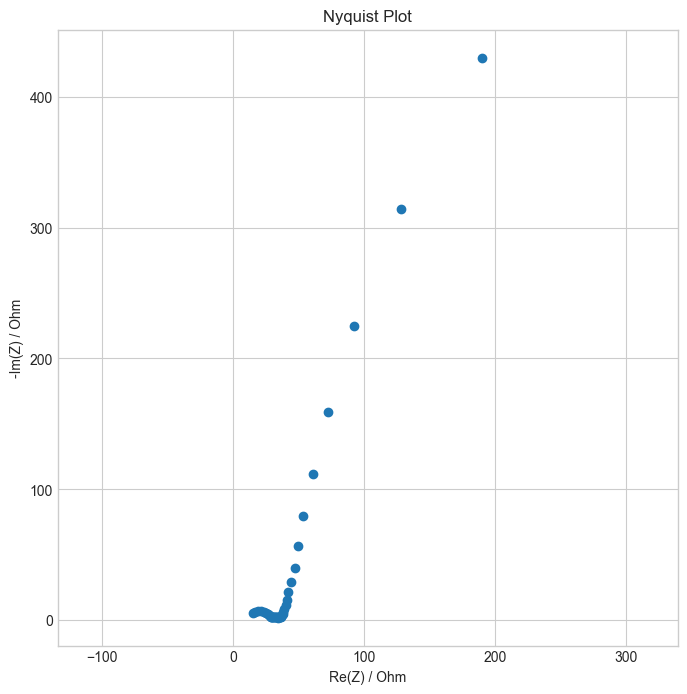

In [7]:
# 绘制电压随时间的变化曲线 (针对 GPCL 数据)
ds = raw_data.data

if 'Voltage_V' in ds and 'Time_s' in ds:
    plt.figure(figsize=(10, 6))
    plt.plot(ds['Time_s'], ds['Voltage_V'], label='Voltage')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.title('Voltage vs Time (Single File)')
    plt.legend()
    plt.show()

# 如果是 PEIS 数据，可以尝试绘制 Nyquist 图
peis_file = data_dir / 'Biologic_EIS.mpt'
if peis_file.exists():
    peis_reader = BiologicMPTReader(filepath=peis_file)
    peis_data, _ = peis_reader.load()
    pds = peis_data.data
    
    if 'Re(Z)/Ohm' in pds and '-Im(Z)/Ohm' in pds:
        plt.figure(figsize=(8, 8))
        plt.scatter(pds['Re(Z)/Ohm'], pds['-Im(Z)/Ohm'])
        plt.xlabel("Re(Z) / Ohm")
        plt.ylabel("-Im(Z) / Ohm")
        plt.title("Nyquist Plot")
        plt.axis('equal')
        plt.show()